
## Описание данных:
#### merge.csv содержит поведение пользователя в потоке кликов и данные о регистрации и профиле пользователя.
* user: уникальный user_id-s
* fraud: зависимая переменная (1 - мошенничество, 0 - не мошенничество)

* click_time: время, когда пользователь щелкнул действие.
* length_of_activity_in_minutes: ожидаемое время завершения действия в минутах.
* promise_reward: обещанное вознаграждение за действие.
* ip_asn_x: ip-asn устройства пользователя
* postback_time: время окончания действия, если оно равно нулю, значит, пользователь завершил действие, и нет activity_status и gain_reward.
* activity_status: статус действия, только «успешно» указывает на полный успех действия.
* gain_reward: вознаграждение, полученное пользователем за выполнение действия.
* fraud: зависимая переменная (1 - мошенничество, 0 - не мошенничество)
* ip_asn_y: кодированный ASN регистрации.
* gender: кодированный пол пользователя.
* marital: семейное положение пользователя.
* email_domain_Other,email_domain_f, email_domain_g, email_domain_Other: зашифрованный домен электронной почты.
* employment_a, employment_e, employment_g,employment_Other: закодированный статус занятости пользователя.
* signup_hour_22:00-01:00, signup_hour_2:00-7:00,signup_hour_8:00-20:00: время регистрации пользователя.
* types_of_pets_1, types_of_pets_2, types_of_pets_3,types_of_pets_Other: списки домашних животных пользователей.

### Есть предположение что  в большинстве случаев для пользователя , если одно  из действий  является мошенничеством, все его предыдущие действия  помечаются как мошенничество. Но это верно не для всех случаев. В нем тоже есть исключения. Это затрудняет наши прогнозы.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('merge.csv')

In [3]:
print(f'Shape of merge data - {data.shape}')

Shape of merge data - (4326293, 26)


In [4]:
data.head(3)

,user,click_time,length_of_activity_in_minutes,promised_reward,ip_asn_x,postback_time,activity_status,gained_reward,fraud,ip_asn_y,...,employment_a,employment_e,employment_g,types_of_pets_Other,types_of_pets_1,types_of_pets_2,types_of_pets_3,signup_hour_22:00-01:00,signup_hour_2:00-7:00,signup_hour_8:00-20:00
0,1000000,2020-05-03 17:33:15,25.0,12300.0,11202,2020-05-03 17:33:50,rejection_type_2,369.0,0,11202,...,0,0,0,1,0,0,0,0,0,1
1,1000000,2020-05-03 17:33:50,25.0,12300.0,11202,NaN,NaN,NaN,0,11202,...,0,0,0,1,0,0,0,0,0,1
2,1000002,2020-05-03 17:34:02,25.0,12300.0,11678,2020-05-03 17:34:40,rejection_type_2,369.0,0,11678,...,0,0,0,1,0,0,0,0,0,1


In [5]:
print(f'Number of duplicates - {data.duplicated().sum()}')

Number of duplicates - 6947


In [6]:
data.drop_duplicates(ignore_index=True, inplace=True)

Is Fraud - 25.34%
Not Fraud - 74.66%


<AxesSubplot:xlabel='fraud', ylabel='count'>

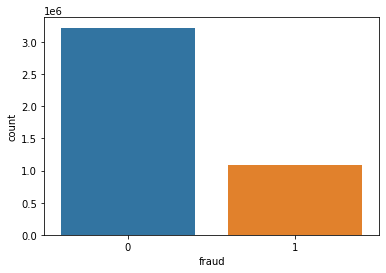

In [7]:
p = round(data.fraud.mean()*100, 2)
print(f'Is Fraud - {p}%')
print(f'Not Fraud - {100-p}%')
sns.countplot(data.fraud)

### Создадим новую переменную "ip_asn_change", если пользователь совершил действие с того же IP адреса на который он зарегестрирован: она примет значение 0, иначе 1, и рассмотрим зависимость с целевой переменной. 

In [8]:
data['ip_asn_change'] = data['ip_asn_x']-data['ip_asn_y']
data.ip_asn_change[data['ip_asn_change']!=0] = 1

data.drop(columns=['ip_asn_x', 'ip_asn_y'], inplace=True)

<AxesSubplot:xlabel='ip_asn_change', ylabel='fraud'>

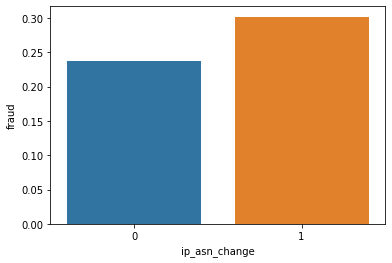

In [9]:
sns.barplot(x='ip_asn_change', y='fraud',
            data=data[['ip_asn_change', 'fraud']].groupby('ip_asn_change').mean().reset_index())

### Наблюдение: 
* Примерно 30% пользователей совершившие действие не с IP адреса их регестрации являются мошенникоми.

In [10]:
round(data.isna().sum()*100/data.shape[0], 2)

user                              0.00
click_time                        0.00
length_of_activity_in_minutes     0.00
promised_reward                   0.00
postback_time                    58.30
activity_status                  58.33
gained_reward                    58.30
fraud                             0.00
gender                            0.00
marital                           0.00
email_domain_Other                0.00
email_domain_f                    0.00
email_domain_g                    0.00
employment_Other                  0.00
employment_a                      0.00
employment_e                      0.00
employment_g                      0.00
types_of_pets_Other               0.00
types_of_pets_1                   0.00
types_of_pets_2                   0.00
types_of_pets_3                   0.00
signup_hour_22:00-01:00           0.00
signup_hour_2:00-7:00             0.00
signup_hour_8:00-20:00            0.00
ip_asn_change                     0.00
dtype: float64

In [11]:
data[data.promised_reward==0].gained_reward.value_counts(dropna=False, normalize=True)

NaN      0.887278
0.0      0.111925
369.0    0.000435
246.0    0.000362
Name: gained_reward, dtype: float64

### Наблюдение: 
* #### Пользователям, котором не было обещано вознаграждение за действие , примерно у 89% случаев  не указано полученное вознаграждение, а в 10% случаев указано 0. Эти наблюдения не являются информативными, поэтому отбросим их.

In [12]:
data.gained_reward.fillna(0, inplace=True)

drop_index=data[(data.promised_reward==0) & (data.gained_reward==0)].index
data.drop(index=drop_index, inplace=True)

### Рассмотрим распределение переменных promised_reward и gained_reward, для мошенников и не мошенников.

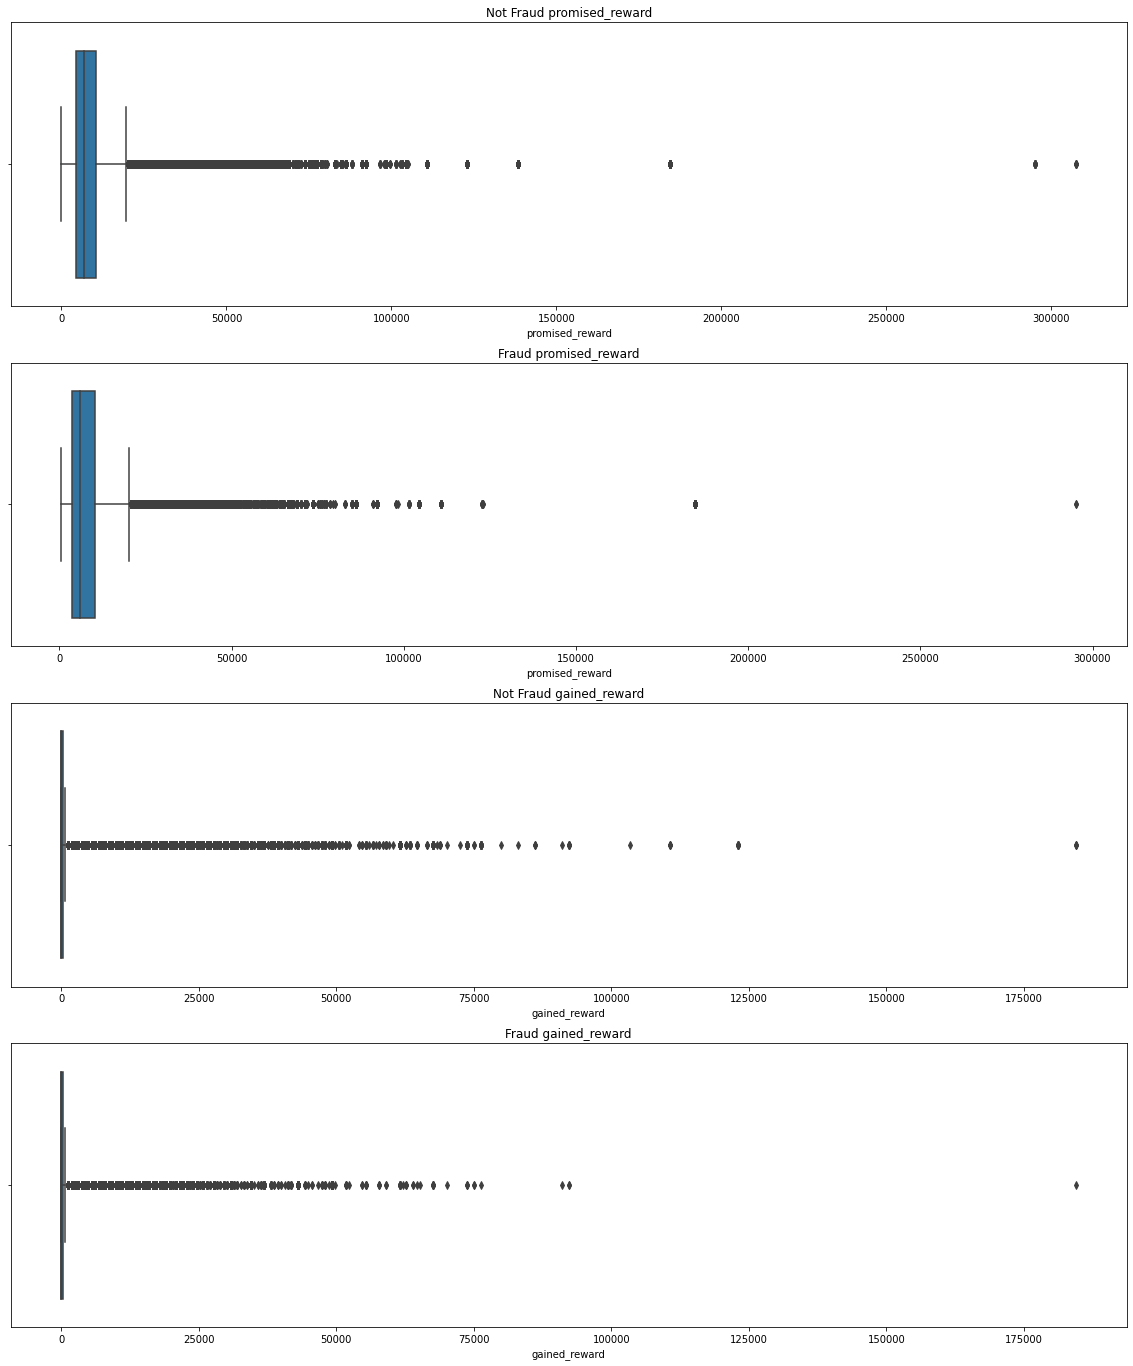

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(20,24))
data_notfraud = data[data.fraud==0]
data_fraud = data[data.fraud==1]

sns.boxplot(x=data_notfraud['promised_reward'], ax=ax[0])
ax[0].title.set_text('Not Fraud promised_reward')
sns.boxplot(x=data_fraud['promised_reward'], ax=ax[1])
ax[1].title.set_text('Fraud promised_reward')
sns.boxplot(x=data_notfraud['gained_reward'], ax=ax[2])
ax[2].title.set_text('Not Fraud gained_reward')
sns.boxplot(x=data_fraud['gained_reward'], ax=ax[3])
ax[3].title.set_text('Fraud gained_reward')
plt.show()

### Наблюдения:
* #### Основная часть значений promised_reward и gained_reward распределенны соответственно от (0, 20000) и ближе к нулю, также есть очень много выбросов.

In [14]:
print('---Description of the not fraudulent Promised and Gained reward---')
data_notfraud[['promised_reward', 'gained_reward']].describe(percentiles=[0.05,0.1,0.2,0.8,0.9])/1000

---Description of the not fraudulent Promised and Gained reward---


,promised_reward,gained_reward
count,3218.753000,3218.753000
mean,9.200149,0.545634
std,9.670448,2.192505
min,0.000000,0.000000
5%,1.845000,0.000000
10%,2.460000,0.000000
20%,3.690000,0.000000
50%,6.765000,0.000000
80%,12.300000,0.369000
90%,18.450000,0.369000


In [15]:
print('---Description of the fraudulent Promised and Gained reward---')
data_fraud[['promised_reward', 'gained_reward']].describe(percentiles=[0.1,0.2,0.8,0.95])/1000

---Description of the fraudulent Promised and Gained reward---


,promised_reward,gained_reward
count,1086.809000,1086.809000
mean,8.964599,0.368517
std,10.289778,1.702381
min,0.615000,0.000000
10%,2.460000,0.000000
20%,3.075000,0.000000
50%,6.150000,0.000000
80%,12.300000,0.369000
95%,27.675000,0.369000
max,295.200000,184.500000


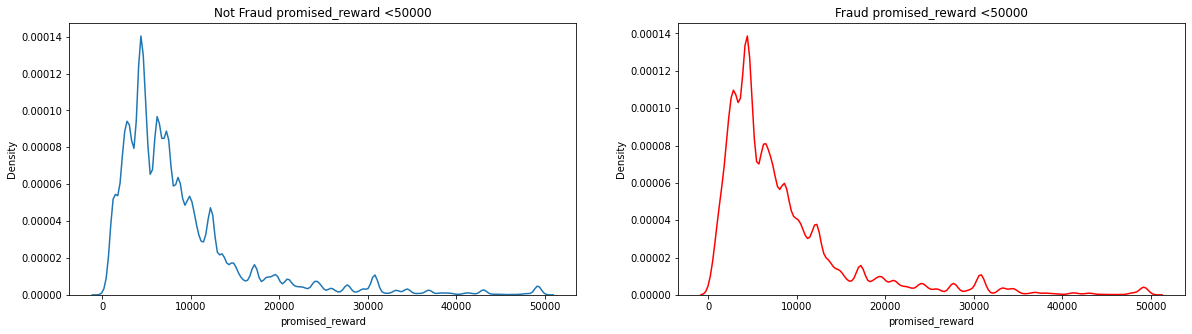

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.kdeplot(data=data_notfraud[data_notfraud["promised_reward"]<50000], x="promised_reward", ax=ax[0]) \
    .set_title('Not Fraud promised_reward <50000')
sns.kdeplot(data=data_fraud[data["promised_reward"]<50000], x="promised_reward", color='r', ax=ax[1]) \
    .set_title('Fraud promised_reward <50000')
plt.show()

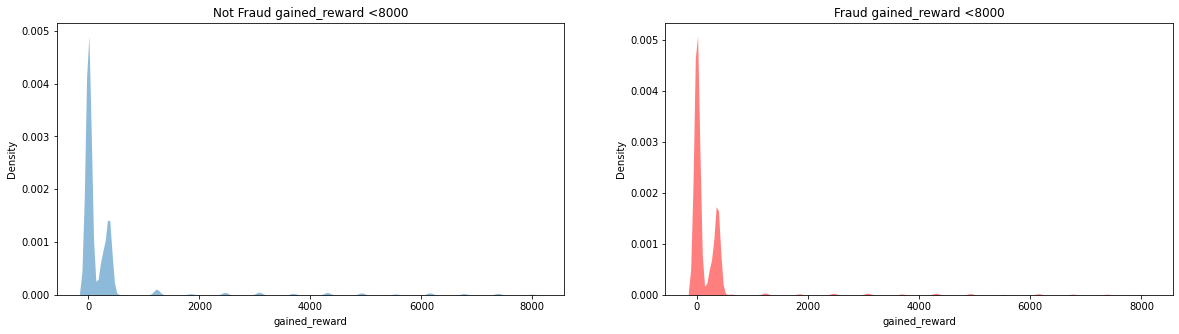

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.kdeplot(data=data_notfraud[data_notfraud["gained_reward"]<8000], x="gained_reward",
                fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,ax=ax[0]) \
            .set_title('Not Fraud gained_reward <8000')
sns.kdeplot(data=data_fraud[data_fraud["gained_reward"]<8000], x="gained_reward",
            fill=True, common_norm=False, color='r', alpha=.5, linewidth=0, ax=ax[1]) \
            .set_title('Fraud gained_reward <8000')
plt.show()

### Наблюдения:
* #### Графики сильно скошенны влево. Целесообразно прологарифмовать их.

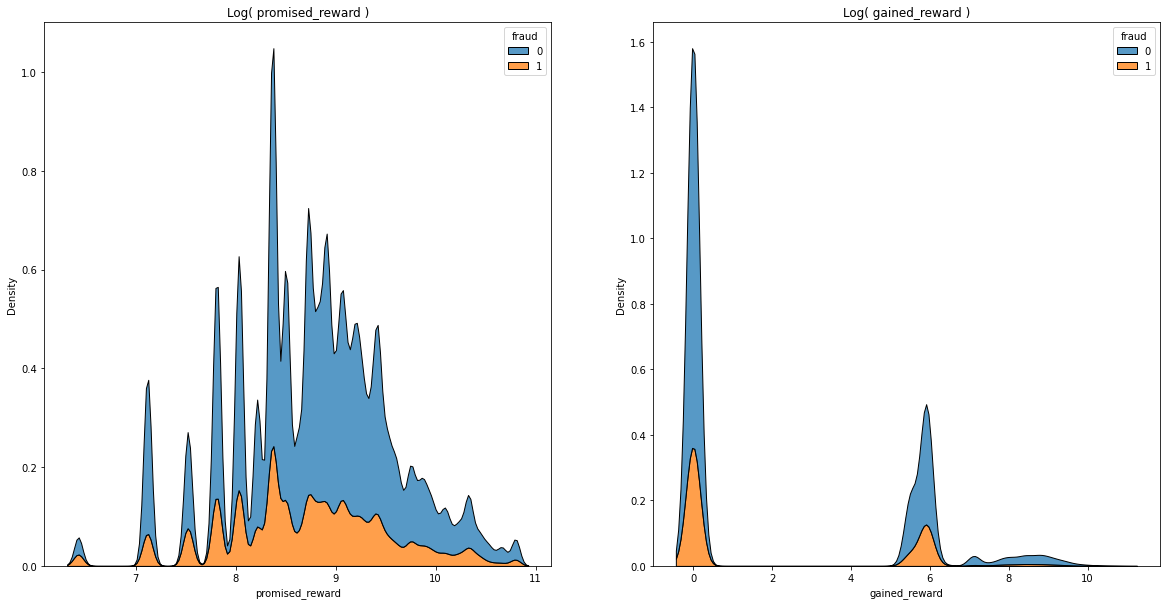

In [18]:
data = data[(data.promised_reward<50000) & (data.promised_reward>500)]

log_data = pd.concat([np.log(data[['gained_reward', 'promised_reward']]+1), data.fraud], axis=1).reset_index(drop=True)
                    
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.kdeplot(data=log_data, x="promised_reward", hue='fraud', multiple="stack", ax=ax[0]) \
    .set_title('Log( promised_reward )')
sns.kdeplot(data=log_data, x="gained_reward", hue='fraud', multiple="stack", ax=ax[1]) \
    .set_title('Log( gained_reward )')
plt.show()

In [19]:
data[['gained_reward', 'promised_reward']] = np.log(data[['gained_reward', 'promised_reward']]+1)


### Вычтем из postback_time значение click_time, чтобы узнать время длительности действия.

In [20]:
time_start = data.click_time.astype('datetime64[ns]')
time_end = data.postback_time.astype('datetime64[ns]')

activity = time_end-time_start
activity

0         0 days 00:00:35
1                     NaT
2         0 days 00:00:38
3                     NaT
4                     NaT
                ...      
4319341               NaT
4319342               NaT
4319343               NaT
4319344               NaT
4319345               NaT
Length: 4276353, dtype: timedelta64[ns]

In [21]:
activity[activity<pd.Timedelta(seconds=0)]

1383      -1 days +23:59:28
7239      -1 days +23:58:47
13242     -1 days +23:46:52
15608     -1 days +23:55:48
16506     -1 days +23:50:40
                 ...       
4292627   -1 days +23:58:07
4304196   -1 days +23:59:20
4316030   -1 days +23:58:24
4318055   -1 days +21:00:42
4318056   -1 days +20:59:06
Length: 753, dtype: timedelta64[ns]

### Наблюдения: 
* #### Присутствуют отрицательные значения.

In [22]:
drop_index = activity[activity<pd.Timedelta(seconds=0)].index
data.drop(index = drop_index, inplace=True)
data['activity_duration'] = activity.fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds()/60)

In [23]:
data['click_time_hour'] = time_start.round('H').dt.hour
data['click_time_day_of_week'] = time_start.dt.dayofweek
data['click_time_month'] = time_start.dt.month

data.drop(['click_time', 'postback_time'], axis=1, inplace=True)

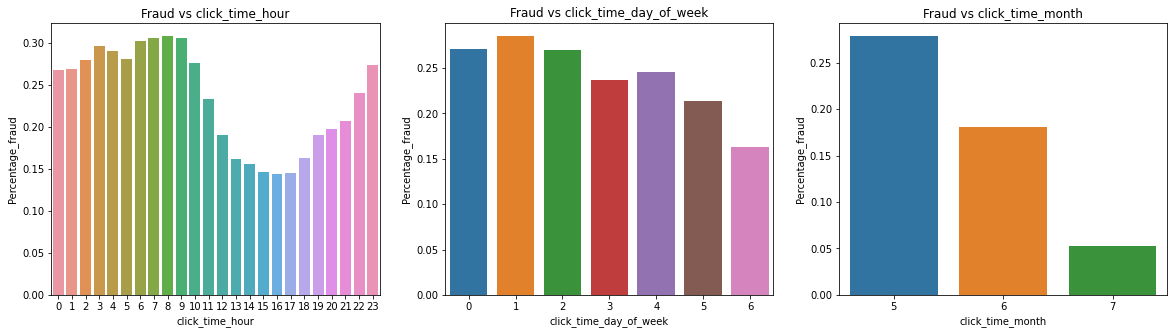

In [24]:
tmp1 = data[['fraud','click_time_hour']].groupby('click_time_hour').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp2 = data[['fraud', 'click_time_day_of_week']].groupby('click_time_day_of_week').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp3 = data[['fraud', 'click_time_month']].groupby('click_time_month').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

fig, ax = plt.subplots(1, 3, figsize=(20,5))

sns.barplot(x='click_time_hour', y='Percentage_fraud',data=tmp1, ax=ax[0])
sns.barplot(x='click_time_day_of_week', y='Percentage_fraud',data=tmp2, ax=ax[1])
sns.barplot(x='click_time_month', y='Percentage_fraud', data=tmp3, ax=ax[2])
ax[0].set_title('Fraud vs click_time_hour')
ax[1].set_title('Fraud vs click_time_day_of_week')
ax[2].set_title('Fraud vs click_time_month')
plt.show()

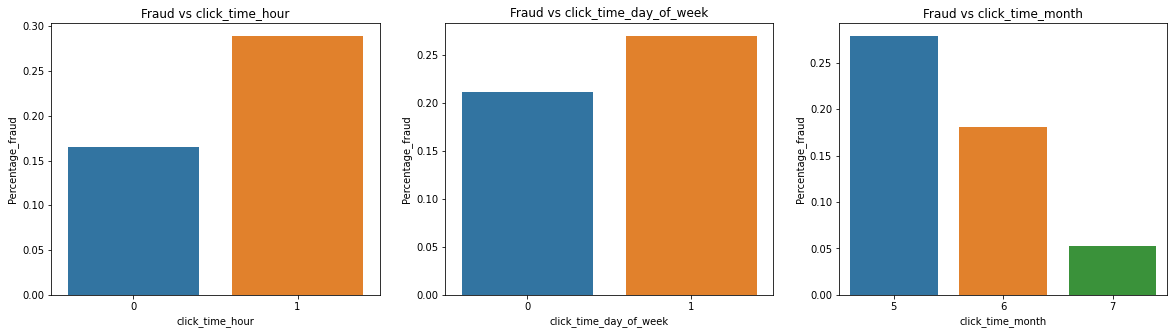

In [25]:
data['click_time_day_of_week'] = data['click_time_day_of_week'].apply(lambda x:0 if x in [3,5,6] else 1)
data['click_time_hour'] = data['click_time_hour'].apply(lambda x:1 if x in [0,1,2,3,4,5,6,7,8,9,10,11,22,23] else 0)
data['click_time_month'] = data['click_time_month'].astype('object')

tmp1 = data[['fraud','click_time_hour']].groupby('click_time_hour').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp2 = data[['fraud', 'click_time_day_of_week']].groupby('click_time_day_of_week').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})
tmp3 = data[['fraud', 'click_time_month']].groupby('click_time_month').mean().reset_index() \
    .rename(columns={'fraud':'Percentage_fraud'})

fig, ax = plt.subplots(1, 3, figsize=(20,5))

sns.barplot(x='click_time_hour', y='Percentage_fraud',data=tmp1, ax=ax[0])
sns.barplot(x='click_time_day_of_week', y='Percentage_fraud',data=tmp2, ax=ax[1])
sns.barplot(x='click_time_month', y='Percentage_fraud', data=tmp3, ax=ax[2])
ax[0].set_title('Fraud vs click_time_hour')
ax[1].set_title('Fraud vs click_time_day_of_week')
ax[2].set_title('Fraud vs click_time_month')
plt.show()

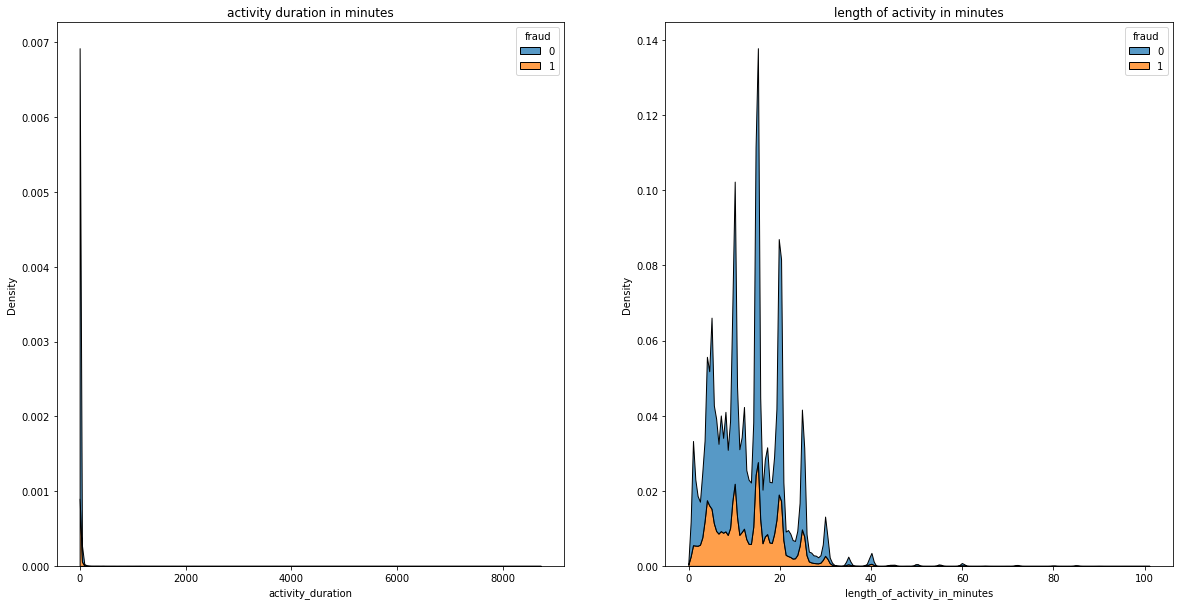

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

sns.kdeplot(data=data, x='activity_duration', hue='fraud', multiple="stack", ax=ax[0]) \
    .set_title('activity duration in minutes')
sns.kdeplot(data=data, x='length_of_activity_in_minutes', hue='fraud', multiple="stack", ax=ax[1]) \
    .set_title('length of activity in minutes')
plt.show()

In [27]:
data[['activity_duration', 'length_of_activity_in_minutes']].describe(percentiles=[0.8, 0.85, 0.9]).astype('int')

,activity_duration,length_of_activity_in_minutes
count,4275600,4275600
mean,2,13
std,18,7
min,0,1
50%,0,13
80%,1,20
85%,2,20
90%,4,22
max,8715,100


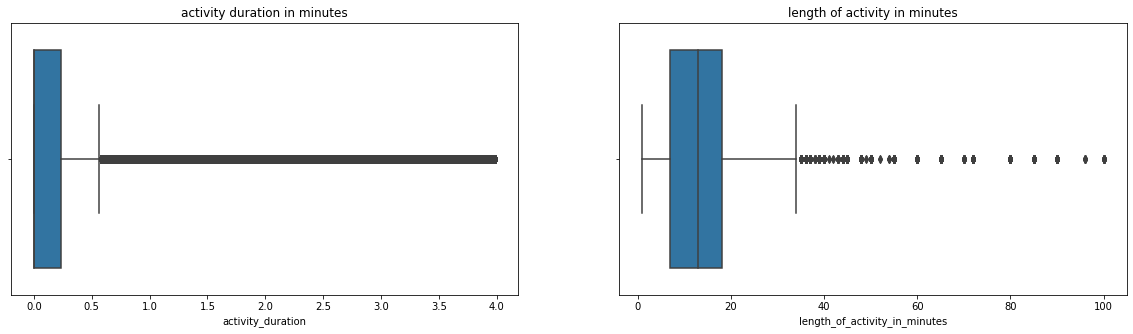

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.boxplot(data=data[data['activity_duration']<4], x='activity_duration', hue='fraud', ax=ax[0]) \
    .set_title('activity duration in minutes')
sns.boxplot(data=data, x='length_of_activity_in_minutes', hue='fraud', ax=ax[1]) \
    .set_title('length of activity in minutes')
plt.show()

In [29]:
data = data[data.activity_duration<3]
data = data[data.length_of_activity_in_minutes<40]

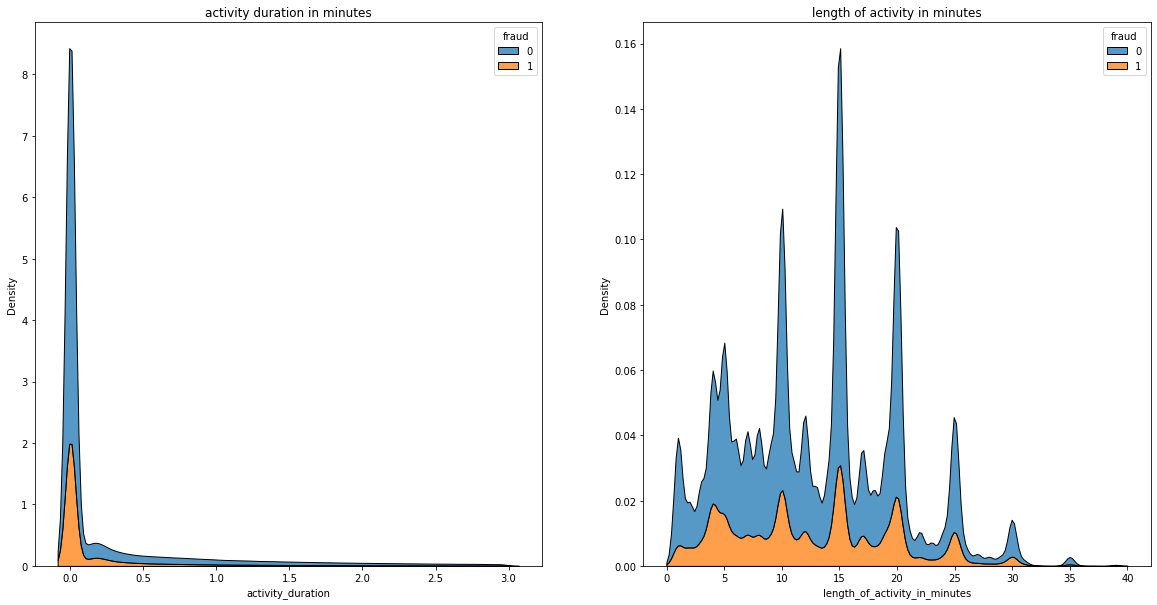

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

sns.kdeplot(data=data, x='activity_duration', hue='fraud', multiple="stack", ax=ax[0]) \
    .set_title('activity duration in minutes')
sns.kdeplot(data=data, x='length_of_activity_in_minutes', hue='fraud', multiple="stack", ax=ax[1]) \
    .set_title('length of activity in minutes')
plt.show()

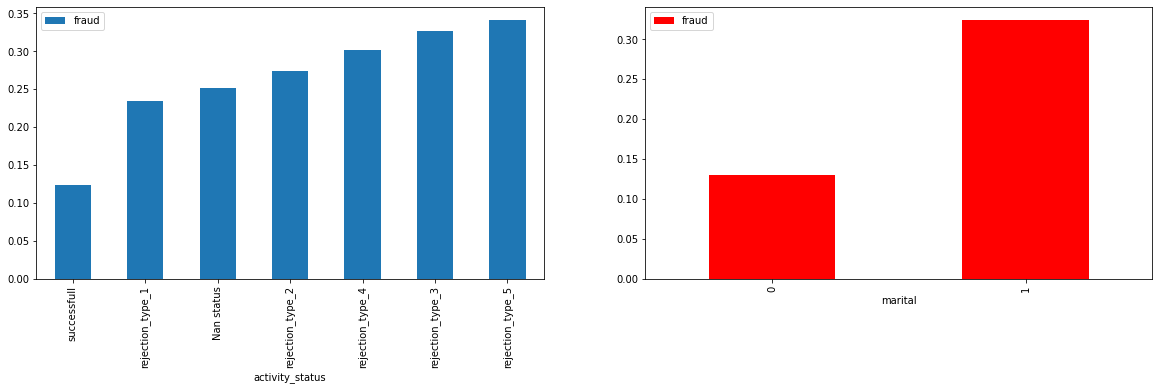

In [31]:
data.activity_status.fillna('Nan status', inplace=True)

fig, ax = plt.subplots(1,2,figsize=(20,5))
data[['fraud','activity_status']].groupby('activity_status').mean().sort_values('fraud').plot(kind='bar', ax=ax[0])
data[['fraud','marital']].groupby('marital').mean().sort_values('fraud').plot(kind='bar', color='r', ax=ax[1])
plt.show()

### Наблюдения:
* #### Действия, у которых статус successfull, 13% мошеннические, остальные типы статусов имеют вероятность от 24%-33%.
* #### У пола 1 высокая вероятность - 33%, а у пола 0 низкая - 13%.

In [32]:
data['activity_status'] = data.activity_status.replace({'Nan status':'Nan_or_rejection_type_1,2',
                                                     'rejection_type_2':'Nan_or_rejection_type_1,2',
                                                     'rejection_type_1':'Nan_or_rejection_type_1,2',
                                                     'rejection_type_3':'rejection_type_3,4,5',
                                                     'rejection_type_4':'rejection_type_3,4,5',
                                                     'rejection_type_5':'rejection_type_3,4,5'})


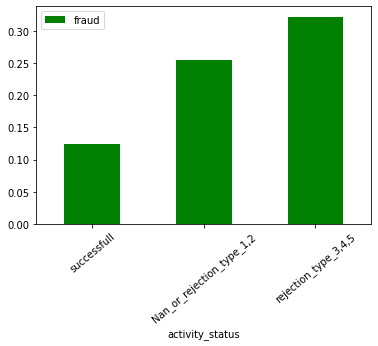

In [33]:
data[['activity_status','fraud']].groupby('activity_status').mean().sort_values('fraud').plot(kind='bar', color='g') 
plt.xticks(rotation=40)
plt.show()

In [34]:
dumies = pd.get_dummies(data[['click_time_month','activity_status']])
data = pd.concat([data, dumies], axis=1).drop(columns = ['click_time_month','activity_status'])


## Корреляционный анализ


<AxesSubplot:>

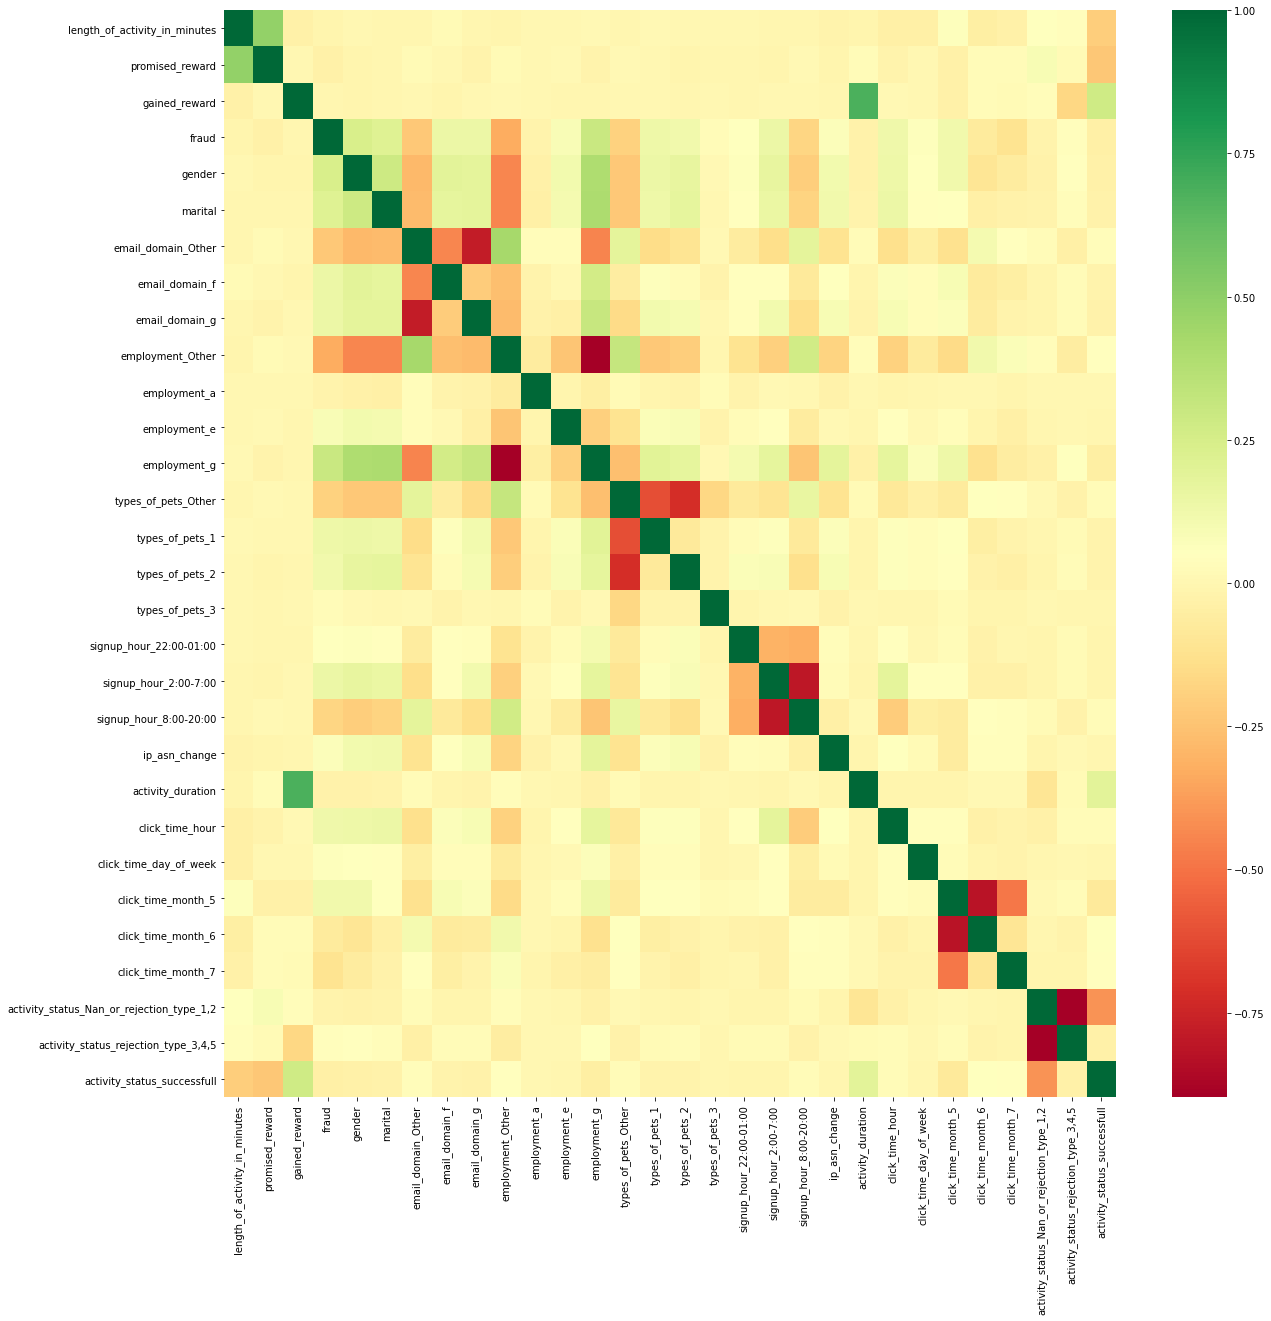

In [35]:
corrmap = data.drop('user', axis=1).corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmap, cmap='RdYlGn')

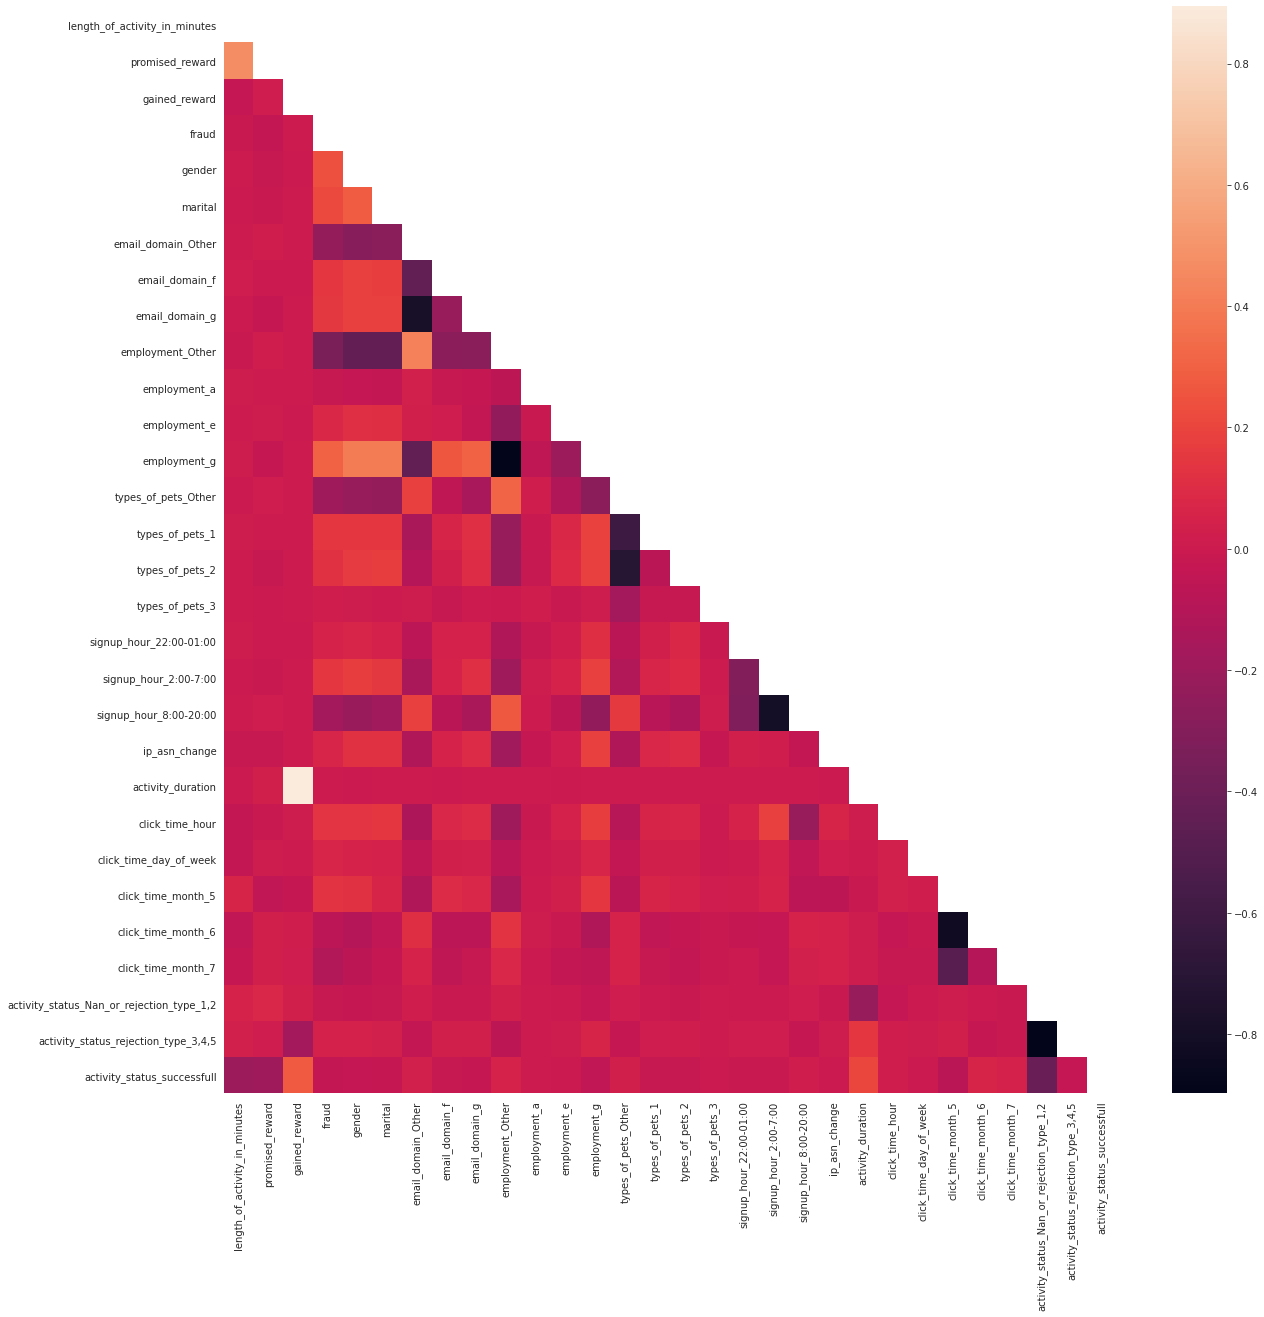

In [36]:
corr = data.drop('user', axis=1).corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,20))
    ax = sns.heatmap(corr, mask=mask)

In [37]:
i=0
corr = data.drop('user', axis=1).corr(method='spearman')
col1, col2, col3 = [], [], []
for col in corr.columns:
    i+=1
    for index in corr.index[i:]:
        if (corr[col][index]>=0.75)or (corr[col][index]<=(-0.75)):
            col1.append(col)
            col2.append(index)
            col3.append(np.round(corr[col][index], 2))
        
corr = pd.DataFrame()
corr["feature_1"] = col1
corr["feature_2"] = col2
corr["correlation"] = col3

corr.sort_values(by='correlation', ascending=False).reset_index(drop=True)

,feature_1,feature_2,correlation
0,gained_reward,activity_duration,0.89
1,email_domain_Other,email_domain_g,-0.78
2,signup_hour_2:00-7:00,signup_hour_8:00-20:00,-0.80
3,click_time_month_5,click_time_month_6,-0.82
4,employment_Other,employment_g,-0.90
5,"activity_status_Nan_or_rejection_type_1,2","activity_status_rejection_type_3,4,5",-0.90


In [ ]:
data.drop(columns=['activity_status_Nan_or_rejection_type_1,2', 'employment_Other'], inplace=True)
data.to_csv('all_data.csv', index=False)